# PERHITUNGAN KATA MENGGUNAKAN APACHE SPARK DAN APACHE HADOOP

### Import Library yang digunakan

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import json

#### Mengunduh model untuk spacy

In [2]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.3 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Konversi data JSON ke Line by Line

In [3]:
input_file = 'relevant_articles_line_by_line.json'
output_file = 'output.txt'

line_number = 0
total_lines = 0

with open(output_file, 'w') as f:
    with open(input_file, 'r') as infile:
        for line in infile:
            line_number += 1
            try:
                data = json.loads(line)
                title = data.get("title", "")
                summary = data.get("sum", "")
                body_text = data.get("body", "")
                text = data.get("text", "")
                concatenated_text = f"{title}\n{summary}\n{body_text}\n{text}\n\n"
                f.write(concatenated_text)
                total_lines += 1
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {line_number}: {e}")

print(f"Processed {total_lines} lines.")


Processed 60795 lines.


### Input data "output.txt" ke Hadoop dengan Spark

In [8]:
# Initialize the Spark session
spark = SparkSession.builder \
    .appName("HDFS Test") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .config("spark.driver.memory", "3g") \
    .config("spark.executor.memory", "3g") \
    .config("spark.python.daemon", "true") \
    .config("spark.python.worker.reuse", "true") \
    .getOrCreate()

local_file_path = "output.txt"

# Read local file
with open(local_file_path, 'r') as f:
    lines = f.readlines()

# Create RDD and parallelize the lines
rdd = spark.sparkContext.parallelize(lines, numSlices=100)

# Save RDD as text file to HDFS
output_path = "hdfs://namenode:9000/input/news"
rdd.saveAsTextFile(output_path)

# Print success notification
print(f"Data has been successfully saved to {output_path}")

Data has been successfully saved to hdfs://namenode:9000/input/newssa


### Melakukan perhitungan kata dengan hadoop

In [5]:
# Path file input in HDFS
file_path = "hdfs://namenode:9000/input/news"

# Read file from HDFS to RDD
rdd = spark.sparkContext.textFile(file_path)

# Peform word count from RDD
word_counts = rdd \
    .flatMap(lambda line: line.split()) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b)

# Convert RDD to DataFrame for word count
df = rdd.flatMap(lambda line: line.split()) \
        .map(lambda word: (word,)) \
        .toDF(["word"])

# Count word using DataFrame
word_counts_df = df.groupBy("word").count()

# Save RDD result to HDFS
output_path = "hdfs://namenode:9000/output/wordcount"
word_counts.saveAsTextFile(output_path)

# Save DataFrame results to ke HDFS in CSV format
word_counts_df.write.option("header", "true").csv("hdfs://namenode:9000/output/wordcount_df")

### Menampilkan hasil dari Word Count 

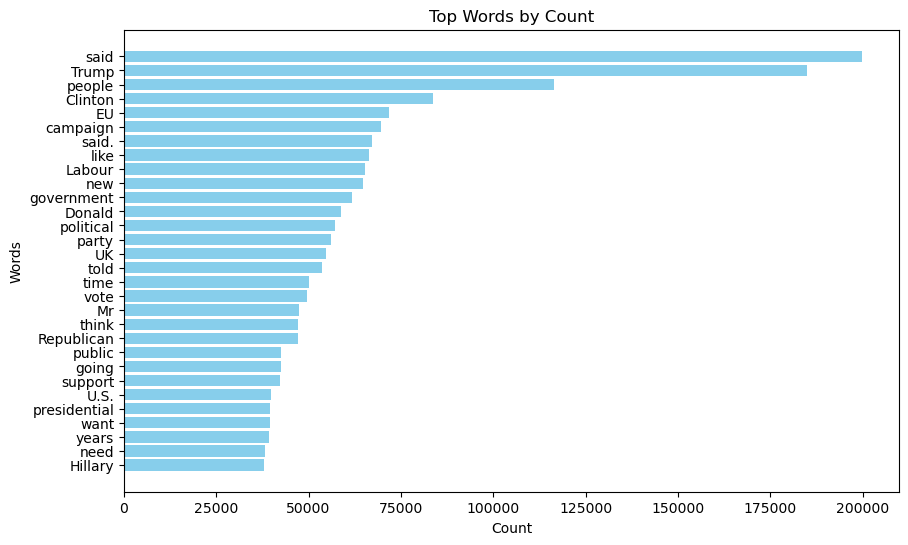

In [6]:
# Read the DataFrame results from HDFS (CSV format)
df_output = spark.read.csv("hdfs://namenode:9000/output/wordcount_dfs", header=True, inferSchema=True)

# Get the top 30 word based on their frequency
top_words = df_output.orderBy("count", ascending=False).toPandas()

nlp = spacy.load("en_core_web_lg")

# Create a set of stop words from spaCy and convert to lowercase
stop_words = set(word.lower() for word in nlp.Defaults.stop_words)

# Convert the 'word' column to lowercase for case-insensitive comparison
top_words['word_lower'] = top_words['word'].str.lower()

# Filter out stop words from the top words DataFrame
filtered_words = top_words[~top_words['word_lower'].isin(stop_words)]
filtered_words = filtered_words[~filtered_words['word'].str.contains(r'–|-|--', regex=True)]
filtered_words = filtered_words.head(30)

plt.figure(figsize=(10, 6))
plt.barh(filtered_words['word'], filtered_words['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Top Words by Count')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
plt.show()